### VM setup

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd "/content/gdrive/MyDrive/Master Thesis/Language Model Training"

/content/gdrive/MyDrive/Master Thesis/Language Model Training


In [3]:
!pip install transformers==4.17

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.8 MB 4.0 MB/s 
     |████████████████████████████████| 880 kB 40.3 MB/s 
     |████████████████████████████████| 6.6 MB 29.9 MB/s 
     |████████████████████████████████| 120 kB 43.0 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=b104eb6e662d29bf6287f8cb6680f92306922eca501b1508e47ef89a1205ca81
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses


In [4]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 365 kB 5.1 MB/s 
     |████████████████████████████████| 212 kB 42.0 MB/s 
     |████████████████████████████████| 115 kB 48.1 MB/s 
     |████████████████████████████████| 127 kB 38.3 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [5]:
import sys
sys.path.insert(0, "/content/gdrive/MyDrive/Master Thesis/ModelFineTuning/")
sys.path.insert(0, "/content/experiments_chd/model_finetuning/TransformerPlusTemporal/")
from hub_token import HUB_TOKEN

In [6]:
import torch
from torch import cuda
import transformers
from transformers import RobertaModel
from transformers import RobertaTokenizerFast
from transformers import TrainerCallback
import datasets
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelBinarizer

from collections import ChainMap
import random
from tqdm import tqdm
import shutil
from datetime import datetime
import json
import os

In [7]:
import multiprocessing

core_count = multiprocessing.cpu_count() # Count the number of cores in a computer
core_count

2

In [8]:
device = 'cuda' if cuda.is_available() else 'cpu'
device

'cpu'

### Load Tokenizer



In [9]:
tokenizer = RobertaTokenizerFast.from_pretrained("./TwitchLeagueBert")

### Data preparation

In [ ]:
# load pre-created huggingface dataset
ds = datasets.load_from_disk("../Data/Fuetal2017/fu2017_highlight_detection_dataset")
ds

### Tokenize

In [ ]:
# test format
tokenizer(ds["train"][0]["messages"].rstrip("\n").split("\n"))

In [ ]:
def split_add_bos_eos(example):
  return {"messages_split": f"{tokenizer.eos_token}{tokenizer.bos_token}".join(example["messages"].rstrip("\n").split("\n"))}

In [ ]:
ds_messages_split = ds.map(split_add_bos_eos, remove_columns=["messages"])

In [ ]:
ds_messages_toked = ds_messages_split.map(lambda examples: tokenizer(examples['messages_split']), batched=True)

In [ ]:
ds_messages_tok_count = ds_messages_toked.map(lambda examples: {"tok_count": [len(ex) for ex in examples["input_ids"]]}, batched=True)

In [ ]:
ds_messages_tok_count

In [ ]:
ds_messages_tok_count["train"][1234203: 1234203+10]

In [ ]:
ds_messages_tok_count.save_to_disk("../Data/Fuetal2017/fu2017_highlight_detection_dataset_tokenized_counted")

### Oversample for balancing

In [ ]:
ds_messages_tok_count = datasets.load_from_disk("../Data/Fuetal2017/fu2017_highlight_detection_dataset_tokenized_counted")

In [ ]:
ds_messages_tok_count

DatasetDict({
    train: Dataset({
        features: ['highlights', 'match_name', 'messages_split', 'input_ids', 'attention_mask', 'tok_count'],
        num_rows: 10580401
    })
    val: Dataset({
        features: ['highlights', 'match_name', 'messages_split', 'input_ids', 'attention_mask', 'tok_count'],
        num_rows: 3305229
    })
    test: Dataset({
        features: ['highlights', 'match_name', 'messages_split', 'input_ids', 'attention_mask', 'tok_count'],
        num_rows: 3984081
    })
})

In [ ]:
sum(ds_messages_tok_count["train"]["highlights"])

1089969

In [ ]:
len(ds_messages_tok_count["train"]["highlights"])

10580401

In [ ]:
ds_messages_tok_count["train"][:5]["highlights"]

[0, 0, 0, 0, 0]

In [ ]:
def over_sample_binary(ds):
  label = np.asarray(ds["highlights"])
  class_counts = (abs(label.size - label.sum()).astype(int), label.sum().astype(int))
  smaller_class = np.argmin(class_counts)

  print(class_counts, smaller_class)
  
  ratio = abs((len(label) - class_counts[smaller_class])/(class_counts[smaller_class]) - 1)
  print(ratio)
  smlclss_inds = np.where(label == smaller_class)[0]
  target = round(class_counts[smaller_class] * ratio)

  # new_data = datasets.Dataset.from_dict({k: np.repeat(v, ratio, axis=0) for k, v in ds[smlclss_inds].items()})
  new_data = {k: np.repeat(v, ratio, axis=0) for k, v in ds[smlclss_inds].items()}
  print("new_data_done")
  # new_data_remainder = datasets.Dataset.from_dict({k: np.asarray(v) for k, v in ds[smlclss_inds[:target - len(new_data["highlights"])]].items()})
  new_data_remainder = datasets.Dataset.from_dict({k: np.asarray(v) for k, v in ds[smlclss_inds[:target - len(new_data["highlights"])]].items()})
  print("new_data_remainder done")
  
  return datasets.concatenate_datasets([ds, new_data, new_data_remainder])

In [ ]:
ds_oversample = over_sample_binary(ds_messages_tok_count["train"]) # OOM

(9490432, 1089969) 1
7.7070659807755995


In [ ]:
ds_messages_tok_count["train"] = ds_oversample

In [ ]:
ds_messages_tok_count.save_to_disk("../Data/Fuetal2017/fu2017_highlight_detection_dataset_tokenized_counted_oversampled")

### Combine data into chunks
Definition:
* each sequence is 128 tokens in length (4 chunks à 32 tokens)
* we classify over 64 tokens in the center of the sequence (2 chunks)
* sliding window by window-length
* first chunk in match only has righthandside context and will be padded from left
* last chunk will be padded from right, chunk ends at match end
* if there is a highlight boundary within the chunk we are trying to classify, we assume the majority of frames as true (very fuzzy): But we cannot use highlight borders as a chunking orientation, because at inference time this information is not available


In [ ]:
ds_messages_tok_count_oversampled = datasets.load_dataset("Epidot/private_fuetal2017_highlights_temporal_preprocessed_TwitchLeagueBert_oversampled", use_auth_token=HUB_TOKEN)

Downloading:   0%|          | 0.00/1.75k [00:00<?, ?B/s]

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/Epidot___parquet/Epidot--private_fuetal2017_highlights_temporal_preprocessed_TwitchLeagueBert_oversampled-4ddedf9a2a24b145/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
ds_messages_tok_count_oversampled

DatasetDict({
    train: Dataset({
        features: ['highlights', 'input_ids', 'attention_mask', 'message_density_scaled', 'hl_labels', 'additional_features'],
        num_rows: 215089
    })
    val: Dataset({
        features: ['highlights', 'input_ids', 'attention_mask', 'message_density_scaled', 'hl_labels', 'additional_features'],
        num_rows: 33160
    })
    test: Dataset({
        features: ['highlights', 'input_ids', 'attention_mask', 'message_density_scaled', 'hl_labels', 'additional_features'],
        num_rows: 34046
    })
})

In [ ]:
def chunk_dataset(ds, max_chunk_len=32):
  cur_chunk_len = 0
  chunk_ids = list()
  tok_counts = ds["tok_count"]
  match_names = ds["match_name"]
  prev_match = match_names[0]

  def add_chunk_id(cids):
      try:
        cids.append(cids[-1])
      except IndexError:
        # should only happen with first entry
        cids.append(0)

  for i in tqdm(range(len(tok_counts))):
    tc = tok_counts[i]
    mn = match_names[i]
    # ignore empty sequences where token count is 2 (only bos and eos)
    # will be removed later
    if tc < 3:
      add_chunk_id(chunk_ids)
      continue
    
    if cur_chunk_len + tc > max_chunk_len:
      # single frames which are too long
      # get their own id and will be truncated later
      chunk_ids.append(chunk_ids[-1] + 1)
      cur_chunk_len = tc
    elif mn != prev_match:
      # cut at match boundary
      chunk_ids.append(chunk_ids[-1] + 1)
      cur_chunk_len = tc
      prev_match = mn
    else:
      add_chunk_id(chunk_ids)
      cur_chunk_len += tc
  return chunk_ids

In [ ]:
ds_messages_chunked = datasets.DatasetDict({ds: ds_messages_tok_count_oversampled[ds].add_column(name="chunk_id", column=chunk_dataset(ds_messages_tok_count_oversampled[ds])) for ds in ds_messages_tok_count_oversampled})

100%|██████████| 3984081/3984081 [00:02<00:00, 1806010.76it/s]


In [ ]:
ds_messages_chunked

DatasetDict({
    train: Dataset({
        features: ['highlights', 'match_name', 'messages_split', 'input_ids', 'attention_mask', 'tok_count', 'chunk_id'],
        num_rows: 10580401
    })
    val: Dataset({
        features: ['highlights', 'match_name', 'messages_split', 'input_ids', 'attention_mask', 'tok_count', 'chunk_id'],
        num_rows: 3305229
    })
    test: Dataset({
        features: ['highlights', 'match_name', 'messages_split', 'input_ids', 'attention_mask', 'tok_count', 'chunk_id'],
        num_rows: 3984081
    })
})

In [ ]:
chunk_id = ds_messages_chunked["train"]["chunk_id"]

In [ ]:
max_chunk_len = chunk_id

In [ ]:
chunk_borders = list()
prev = 0
for i, val in enumerate(chunk_id):
  if prev != val:
    chunk_borders.append(i)
  prev = val
if chunk_borders[-1] != i:
  chunk_borders.append(i)

In [ ]:
chunk_lens = list()
prev = 0
for cb in chunk_borders:
  chunk_lens.append(cb-prev)
  prev = cb

In [ ]:
max(chunk_lens)

1948

In [ ]:
# get a sample of chunks
prev_b = 0
msg_chunks = list()
input_ids_chunks = list()
for i, b in enumerate(chunk_borders[:10]):
  msg_chunks.append(ds_messages_chunked["train"][prev_b:b]["messages_split"])
  input_ids_chunks.append(ds_messages_chunked["train"][prev_b:b]["input_ids"])
  prev_b = b  

In [ ]:
msg_chunks = [[m for m in c if m != ""] for c in msg_chunks]
input_ids_chunks = [[m for m in c if m != ""] for c in input_ids_chunks]

In [ ]:
msg_chunks

[['lirik subs lirikPUKE', 'COP GOD COACH Kreygams', 'Ray PogChamp'],
 ['EL RAYO PogChamp EL CONTRATO PogChamp EL ENCARNADO PogChamp EL SIGILOSO PogChamp EL SUAVE',
  'TTours TTours',
  'pick karthus'],
 ['PogChamp',
  'OMAR GODYA 5ara',
  'Kreygasm twitch chat Kreygasm',
  'LOD stand for lord of destruction diablo 2?'],
 ['LOD is bad tho',
  'Kreygasm Kreygasm SASHA GREY Kreygasm Kreygasm',
  'RAY PogChamp',
  'atpLaw atpCop',
  'cmonBruh'],
 ['@Pnumatic, aint she ded bruh',
  'DIG JATT',
  'TriHard RUN',
  'Kreygasm ZACH SCHUDERI Kreygasm'],
 ['EUASIAN LCS but finals in Vancouver EleGiggle',
  'NICK MORENO Kreygasm',
  'is this LCK? Kappa',
  'No Impact NotLikeThis'],
 ['OH JOHNY Kreygasm',
  'No Impact Kappa',
  'TriHard COPS RUN BOIS TriHard',
  '@Liyahballerina hi',
  'shen permaban'],
 ['RAY VS SSUMDAY?', 'Thanks C9 for destroying my LCS Fantasy weekj'],
 ['Kreygasm Billy Cranston Kappa</s><s>COP PogChamp PogChamp PogChamp PogChamp',
  "LET'S GO BBY lyn4"],
 ['CALL ME WHEN IMPACT 

### Calculate temporal features

What size window should we use for calculating temporal measures?

As the input chunk is independent of the number of frames it contains, we have to define a window around it which is fixed (for comparability) and fits the input chunks

If the window size is too small:
* we might not cover the whole input region
* we get a highger fluctuation in the measures

If the window size is too large:
* we pack too much potentially unuseful information into the measures


IDEA: for each chunk add multiple windows of chat measures computed around the chunk: before, within, after, total

#### Chunk length with respect to frames

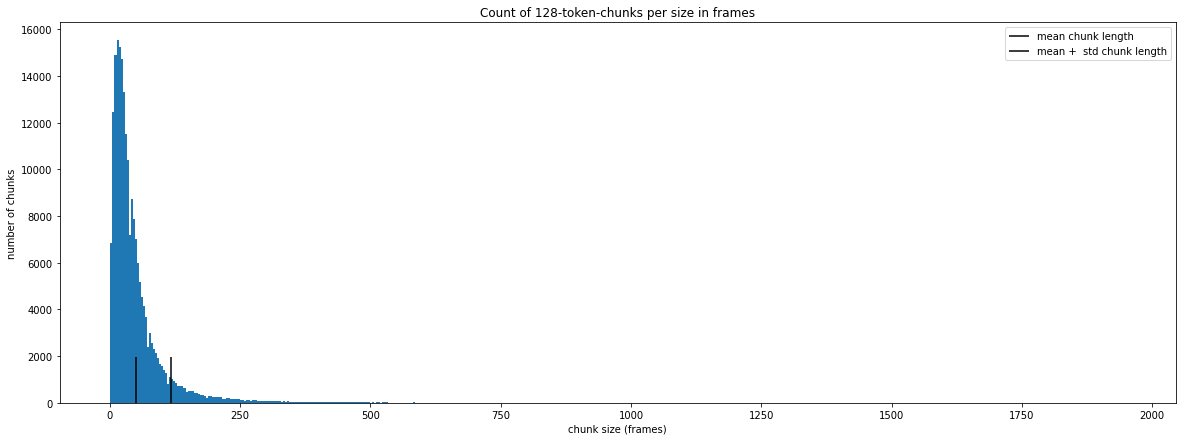

In [ ]:
plt.figure(figsize=(20,7))
plt.hist(chunk_lens, bins=500)
#plt.xlim(0,1000)
plt.vlines(np.mean(chunk_lens), ymin=0, ymax=max(chunk_lens), label="mean chunk length")
plt.vlines(np.mean(chunk_lens) + np.std(chunk_lens), ymin=0, ymax=max(chunk_lens), label="mean +  std chunk length")

plt.title("Count of 128-token-chunks per size in frames")
plt.xlabel("chunk size (frames)")
plt.ylabel("number of chunks")
plt.legend()
plt.show()

In [ ]:
print("min", np.min(chunk_lens))
print("max", np.max(chunk_lens))
print("mean", np.mean(chunk_lens))
print("std", np.std(chunk_lens))

print("window_size", np.mean(chunk_lens) + np.std(chunk_lens))
print("window_size seconds:", (np.mean(chunk_lens) + np.std(chunk_lens)) / 30)

min 1
max 1948
mean 50.74483697998101
std 66.17456620068869
window_size 116.91940318066969
window_size seconds: 3.8973134393556563


In [ ]:
# if we use a 15.26 second window we get windows which are not too small for 91% of the data.
sum(np.asarray(chunk_lens) <= (np.mean(chunk_lens) + np.std(chunk_lens))) / len(chunk_lens)

0.9164036795810112

In [ ]:
sum(np.asarray(chunk_lens) <= 1000)/len(chunk_lens)

0.9997697863809459

#### Calculate temporal chat features

In [ ]:
# from torch.nn.modules.module import T
# copied from chat_measures.py

def msg_dens_dataset(ds):
    match_name = ds["match_name"]
    prev = ds["match_name"][0]
    prev_cut = 0
    msg_dens = list()
    messages = ds["messages_split"]
    for i in tqdm(range(len(match_name))):
      val = match_name[i]
      if prev != val:
        md = moving_avg(message_density(messages[prev_cut:i]), N=1000)
        msg_dens.extend(md)
        prev_cut = i
      prev = val
    msg_dens.extend(moving_avg(message_density(messages[prev_cut:i+1]), N=1000))
    return msg_dens

def message_density(cd, window_size=1000, step_size=1):
    msg_counts = np.asarray(message_counts(cd))
    msg_density = list()

    if window_size == 1 and step_size == 1:
        return msg_counts

    for i in range(0, len(cd), step_size):
        start_ind = max(0, int(i - window_size / 2)) # window centered around frame
        end_ind = min(len(msg_counts), int(i + window_size / 2)) # window centered around frame
        msg_density.append(msg_counts[start_ind:end_ind].sum())
    return np.asarray(msg_density)

def message_counts(cd):
    msg_cnts = list()
    for frame in cd:
        if frame == "":
            msg_cnts.append(0)
        else:
            msg_cnts.append(len(unpack_messages([frame])))
    return msg_cnts

def unpack_messages(cd):
    """
    :param cd: iterable of strings with chat messages, individual messages separated by '\n'
    :return: unpacked messages in iterable, one string per message, no empty strings returned
    """
    unpacked = []
    for m in cd:
        ms = m.split("</s><s>")
        unpacked.extend([m1 for m1 in ms if len(m1) > 0])
    return unpacked

def moving_avg(mylist, N=5):
    try:
        shape = mylist.shape
        mylist = np.ravel(mylist)
    except AttributeError:
        shape = (1, -1)

    cumsum, moving_aves = [0], []

    for i, x in enumerate(mylist, 1):
        cumsum.append(cumsum[i-1] + x)
        if i>=N:
            moving_ave = (cumsum[i] - cumsum[i-N])/N
            #can do stuff with moving_ave here
            moving_aves.append(moving_ave)
    diff = len(mylist) - len(moving_aves)
    if diff > 0:
        tmp = [0 for i in range(diff)]
        tmp.extend(moving_aves)
        moving_aves = tmp
    return np.asarray(moving_aves).reshape(shape)

In [ ]:
ds_messages_chunked_tempfeat = datasets.DatasetDict({ds: ds_messages_chunked[ds].add_column(name="message_density", column=msg_dens_dataset(ds_messages_chunked[ds])) for ds in ds_messages_chunked})

100%|██████████| 3984081/3984081 [00:23<00:00, 172214.89it/s]


In [ ]:
ds_messages_chunked_tempfeat

DatasetDict({
    train: Dataset({
        features: ['highlights', 'match_name', 'messages_split', 'input_ids', 'attention_mask', 'tok_count', 'chunk_id', 'message_density'],
        num_rows: 10580401
    })
    val: Dataset({
        features: ['highlights', 'match_name', 'messages_split', 'input_ids', 'attention_mask', 'tok_count', 'chunk_id', 'message_density'],
        num_rows: 3305229
    })
    test: Dataset({
        features: ['highlights', 'match_name', 'messages_split', 'input_ids', 'attention_mask', 'tok_count', 'chunk_id', 'message_density'],
        num_rows: 3984081
    })
})

In [ ]:
ds_messages_chunked_tempfeat.save_to_disk("../Data/Fuetal2017/fu2017_highlight_detection_dataset_chunked_temporalfeatures")

In [ ]:
ds_messages_chunked_tempfeat = datasets.load_from_disk("../Data/Fuetal2017/fu2017_highlight_detection_dataset_chunked_temporalfeatures")

In [ ]:
ds_messages_chunked_tempfeat

DatasetDict({
    train: Dataset({
        features: ['highlights', 'match_name', 'messages_split', 'input_ids', 'attention_mask', 'tok_count', 'chunk_id', 'message_density'],
        num_rows: 10580401
    })
    val: Dataset({
        features: ['highlights', 'match_name', 'messages_split', 'input_ids', 'attention_mask', 'tok_count', 'chunk_id', 'message_density'],
        num_rows: 3305229
    })
    test: Dataset({
        features: ['highlights', 'match_name', 'messages_split', 'input_ids', 'attention_mask', 'tok_count', 'chunk_id', 'message_density'],
        num_rows: 3984081
    })
})

In [ ]:
scaler = MinMaxScaler()
ds_messages_chunked_tempfeat_scld = datasets.DatasetDict()
ds_messages_chunked_tempfeat_scld["train"] = ds_messages_chunked_tempfeat["train"].add_column(name="message_density_scaled", column=scaler.fit_transform(np.asarray(ds_messages_chunked_tempfeat["train"]["message_density"]).reshape(-1,1)).ravel())
ds_messages_chunked_tempfeat_scld["val"] = ds_messages_chunked_tempfeat["val"].add_column(name="message_density_scaled", column=scaler.transform(np.asarray(ds_messages_chunked_tempfeat["val"]["message_density"]).reshape(-1,1)).ravel())
ds_messages_chunked_tempfeat_scld["test"] = ds_messages_chunked_tempfeat["test"].add_column(name="message_density_scaled", column=scaler.transform(np.asarray(ds_messages_chunked_tempfeat["test"]["message_density"]).reshape(-1,1)).ravel())

In [ ]:
len(ds_messages_chunked_tempfeat)

3

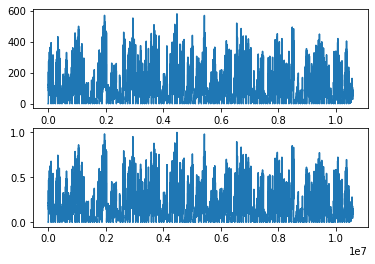

In [ ]:
fig, axs = plt.subplots(2,1)
axs[0].plot(list(range(len(ds_messages_chunked_tempfeat_scld["train"]))), ds_messages_chunked_tempfeat_scld["train"]["message_density"])
axs[1].plot(list(range(len(ds_messages_chunked_tempfeat_scld["train"]))), ds_messages_chunked_tempfeat_scld["train"]["message_density_scaled"])

### Calculate additional learning objective

In [ ]:
def highlight_span(hl):
    """
    extracts beginning and end indices for each highlight in hl
    :param hl: iterable of 0 for non-hihglight frame and 1 for highlight frame
    :return: tuples of indices over all frames in hl where highlights are found
    """
    hls = list()

    prev = -1
    for i, frame in enumerate(hl):
        if frame == 1 and prev < 1:
            hls.append((i, -1))
        if frame == 0 and prev == 1:
            hls[-1] = (hls[-1][0], i-1)
        prev = frame

    if len(hls) > 0 and hls[-1][1] < 0:
        # highlight goes until the end
        hls[-1] = (hls[-1][0], hl.shape[0]-1)
    return hls

In [ ]:
def get_decay(seq_len, max_decay_len, strength):
    # https://en.wikipedia.org/wiki/Exponential_decay
    decay_len = min(max_decay_len, seq_len)
    decay_seq = np.exp(-strength * np.linspace(0,1,num=decay_len))
    if max_decay_len < seq_len:
        return np.concatenate([decay_seq, np.zeros(seq_len - max_decay_len)])
    else:
        return decay_seq

#### distance between highlights

In [ ]:
def generate_highlight_distances(hl_spans, vid_len, decay, max_decay_len, mode):
    assert mode in ["prev", "next"]
    last = 0
    hl_signal = list()
    for start, stop in hl_spans:
        decay_vals = get_decay(start - last, max_decay_len, decay)
        if mode == "prev":
            if last == 0:
                decay_vals = [0] * start
            hl_signal.extend(decay_vals)
        if mode == "next":
            hl_signal.extend(decay_vals[::-1])
        # add in length of highlight
        hl_signal.extend([1] * (stop - start))
        last = stop
    if mode == "prev":
        hl_signal.extend([0] * (vid_len - last))
    if mode == "next":
        hl_signal.extend(get_decay(vid_len - last, max_decay_len, decay))
    return hl_signal

In [ ]:
def highlight_inds_to_highlight_distance(ds, mode, **kwargs):
  hls = ds["highlights"]
  #TODO: consider when matches end, highlight decay should not bleed into next match
  highlight_spans = highlight_span(hls)

  return generate_highlight_distances(highlight_spans, len(hls), mode=mode, **kwargs)

In [ ]:
hl_distance_args = {"prev": {"decay": 6, "max_decay_len": 5000},
                    "next": {"decay": 10, "max_decay_len": 2000}
                    }

In [ ]:
ds_chk_tmpft_hldist = datasets.DatasetDict({"train": None, "val": None, "test": None})

In [ ]:
for ds in ds_messages_chunked_tempfeat:
  ds_new = ds_messages_chunked_tempfeat[ds].add_column(
        name=f"hl_dist_prev", column=highlight_inds_to_highlight_distance(
            ds_messages_chunked_tempfeat[ds], "prev", **hl_distance_args["prev"]))
  ds_new = ds_new.add_column(
        name=f"hl_dist_next", column=highlight_inds_to_highlight_distance(
            ds_new, "next", **hl_distance_args["next"]))
  ds_chk_tmpft_hldist[ds] = ds_new

In [ ]:
ds_chk_tmpft_hldist

DatasetDict({
    train: Dataset({
        features: ['highlights', 'match_name', 'messages_split', 'input_ids', 'attention_mask', 'tok_count', 'chunk_id', 'message_density', 'hl_dist_prev', 'hl_dist_next'],
        num_rows: 10580401
    })
    val: Dataset({
        features: ['highlights', 'match_name', 'messages_split', 'input_ids', 'attention_mask', 'tok_count', 'chunk_id', 'message_density', 'hl_dist_prev', 'hl_dist_next'],
        num_rows: 3305229
    })
    test: Dataset({
        features: ['highlights', 'match_name', 'messages_split', 'input_ids', 'attention_mask', 'tok_count', 'chunk_id', 'message_density', 'hl_dist_prev', 'hl_dist_next'],
        num_rows: 3984081
    })
})

discretize the previous / next highlight output

In [ ]:
hldp = ds_chk_tmpft_hldist["train"]["hl_dist_prev"]

In [ ]:
hldn = ds_chk_tmpft_hldist["train"]["hl_dist_next"]

In [ ]:
num_steps = 5

In [ ]:
hldpd = np.floor(np.asarray(hldp) * num_steps) / num_steps

In [ ]:
hldnd = np.floor(np.asarray(hldn) * num_steps) / num_steps

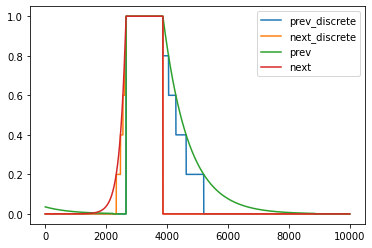

In [ ]:
plt.plot(range(10000), hldpd[40000:50000], label="prev_discrete")
plt.plot(range(10000), hldnd[40000:50000], label="next_discrete")
plt.plot(range(10000), hldp[40000:50000], label="prev")
plt.plot(range(10000), hldn[40000:50000], label="next")
plt.legend()
plt.show()

#### highlight duration since start and until end


In [ ]:
def generate_highlight_durations(hl_spans, vid_len, decay, max_decay_len, mode):
    assert mode in ["start", "stop"]
    hl_signal = list()
    last = 0
    for start, stop in hl_spans:
        hl_signal.extend(np.zeros(start-last))
        decay_vals = get_decay(stop-start, max_decay_len, decay)
        if mode == "start":
            hl_signal.extend(decay_vals)
        if mode == "stop":
            hl_signal.extend(decay_vals[::-1])
        # add in length of highlight
        last = stop
    hl_signal.extend(np.zeros(vid_len-last))
    return hl_signal

In [ ]:
def highlight_inds_to_highlight_decay_signal(ds, mode, **kwargs):
  hls = ds["highlights"]
  highlight_spans = highlight_span(hls)

  return generate_highlight_durations(highlight_spans, len(hls), mode=mode, **kwargs)

In [ ]:
hl_duration_args = {"start": {"decay": 7, "max_decay_len": 1000},
                    "stop": {"decay": 7, "max_decay_len": 1000}
                    }

In [ ]:
ds_chk_tmpft_hldist_hldur = datasets.DatasetDict({"train": None, "val": None, "test": None})

In [ ]:
for ds in ds_chk_tmpft_hldist:
  ds_new = ds_chk_tmpft_hldist[ds].add_column(
        name=f"hl_dist_start", column=highlight_inds_to_highlight_decay_signal(
            ds_chk_tmpft_hldist[ds], "start", **hl_duration_args["start"]))
  ds_new = ds_new.add_column(
        name=f"hl_dist_stop", column=highlight_inds_to_highlight_decay_signal(
            ds_new, "stop", **hl_duration_args["stop"]))
  ds_chk_tmpft_hldist_hldur[ds] = ds_new

In [ ]:
ds_chk_tmpft_hldist_hldur

DatasetDict({
    train: Dataset({
        features: ['highlights', 'match_name', 'messages_split', 'input_ids', 'attention_mask', 'tok_count', 'chunk_id', 'message_density', 'hl_dist_prev', 'hl_dist_next', 'hl_dist_start', 'hl_dist_stop'],
        num_rows: 10580401
    })
    val: Dataset({
        features: ['highlights', 'match_name', 'messages_split', 'input_ids', 'attention_mask', 'tok_count', 'chunk_id', 'message_density', 'hl_dist_prev', 'hl_dist_next', 'hl_dist_start', 'hl_dist_stop'],
        num_rows: 3305229
    })
    test: Dataset({
        features: ['highlights', 'match_name', 'messages_split', 'input_ids', 'attention_mask', 'tok_count', 'chunk_id', 'message_density', 'hl_dist_prev', 'hl_dist_next', 'hl_dist_start', 'hl_dist_stop'],
        num_rows: 3984081
    })
})

In [ ]:
ds_chk_tmpft_hldist_hldur

In [ ]:
scaler = MinMaxScaler()
ds_chk_tmpft_scld_hldist_hldur = datasets.DatasetDict()
ds_chk_tmpft_scld_hldist_hldur["train"] = ds_chk_tmpft_hldist_hldur["train"].add_column(name="message_density_scaled", column=scaler.fit_transform(np.asarray(ds_messages_chunked_tempfeat["train"]["message_density"]).reshape(-1,1)).ravel())
ds_chk_tmpft_scld_hldist_hldur["val"] = ds_chk_tmpft_hldist_hldur["val"].add_column(name="message_density_scaled", column=scaler.transform(np.asarray(ds_messages_chunked_tempfeat["val"]["message_density"]).reshape(-1,1)).ravel())
ds_chk_tmpft_scld_hldist_hldur["test"] = ds_chk_tmpft_hldist_hldur["test"].add_column(name="message_density_scaled", column=scaler.transform(np.asarray(ds_messages_chunked_tempfeat["test"]["message_density"]).reshape(-1,1)).ravel())

In [ ]:
ds_chk_tmpft_scld_hldist_hldur

DatasetDict({
    train: Dataset({
        features: ['highlights', 'match_name', 'messages_split', 'input_ids', 'attention_mask', 'tok_count', 'chunk_id', 'message_density', 'hl_dist_prev', 'hl_dist_next', 'hl_dist_start', 'hl_dist_stop', 'message_density_scaled'],
        num_rows: 10580401
    })
    val: Dataset({
        features: ['highlights', 'match_name', 'messages_split', 'input_ids', 'attention_mask', 'tok_count', 'chunk_id', 'message_density', 'hl_dist_prev', 'hl_dist_next', 'hl_dist_start', 'hl_dist_stop', 'message_density_scaled'],
        num_rows: 3305229
    })
    test: Dataset({
        features: ['highlights', 'match_name', 'messages_split', 'input_ids', 'attention_mask', 'tok_count', 'chunk_id', 'message_density', 'hl_dist_prev', 'hl_dist_next', 'hl_dist_start', 'hl_dist_stop', 'message_density_scaled'],
        num_rows: 3984081
    })
})

In [ ]:
ds_chk_tmpft_scld_hldist_hldur.save_to_disk("../Data/Fuetal2017/fu2017_highlight_detection_dataset_chunked_temporalfeatures_additional_signal")

In [ ]:
ds_chk_tmpft_scld_hldist_hldur = datasets.load_from_disk("../Data/Fuetal2017/fu2017_highlight_detection_dataset_chunked_temporalfeatures_additional_signal")

discretize and one-hot-encode signal for additional (should be done later)

In [ ]:
# discretize hl_distances and hl_durations
def discretize_signal_batch(signal_batch, num_steps):
  ret_batch = list()
  for seq in signal_batch:
    ret_batch.append(np.floor(np.asarray(seq) * num_steps) / num_steps)
  return ret_batch

In [ ]:
for c in ['hl_dist_prev', 'hl_dist_next', 'hl_dist_start', 'hl_dist_stop']:
  ds_chk_tmpft_scld_hldist_hldur = ds_chk_tmpft_scld_hldist_hldur.map(lambda examples: {f"{c}_disc" :discretize_signal_batch(examples[c], 5)}, batched=True, remove_columns=[c], batch_size=1000)

In [ ]:
ds_chk_tmpft_scld_hldist_hldur

DatasetDict({
    train: Dataset({
        features: ['highlights', 'match_name', 'messages_split', 'input_ids', 'attention_mask', 'tok_count', 'chunk_id', 'message_density', 'hl_dist_prev', 'hl_dist_next', 'hl_dist_start', 'hl_dist_stop', 'message_density_scaled'],
        num_rows: 10580401
    })
    val: Dataset({
        features: ['highlights', 'match_name', 'messages_split', 'input_ids', 'attention_mask', 'tok_count', 'chunk_id', 'message_density', 'hl_dist_prev', 'hl_dist_next', 'hl_dist_start', 'hl_dist_stop', 'message_density_scaled'],
        num_rows: 3305229
    })
    test: Dataset({
        features: ['highlights', 'match_name', 'messages_split', 'input_ids', 'attention_mask', 'tok_count', 'chunk_id', 'message_density', 'hl_dist_prev', 'hl_dist_next', 'hl_dist_start', 'hl_dist_stop', 'message_density_scaled'],
        num_rows: 3984081
    })
})

In [ ]:
tdat = ds_chk_tmpft_scld_hldist_hldur["train"][150000:200000]["hl_dist_next_disc"]

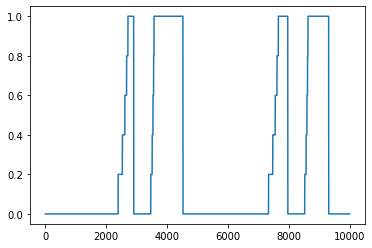

In [ ]:
plt.plot(list(range(10000)), tdat[:10000])

### Data chunking

chunking definition: 
* window_size: 2 number of chunks in window to be classified
* context_size: (1,1) number of chunks to left and right of window
* step_size: 3 how many chunks to step over (if same as window_size + context_size[0], then non-overlapping)

In [ ]:
ds_chk_tmpft_scld_hldist_hldur

DatasetDict({
    train: Dataset({
        features: ['highlights', 'match_name', 'messages_split', 'input_ids', 'attention_mask', 'tok_count', 'chunk_id', 'message_density', 'message_density_scaled', 'hl_dist_prev_disc', 'hl_dist_next_disc', 'hl_dist_start_disc', 'hl_dist_stop_disc'],
        num_rows: 10580401
    })
    val: Dataset({
        features: ['highlights', 'match_name', 'messages_split', 'input_ids', 'attention_mask', 'tok_count', 'chunk_id', 'message_density', 'message_density_scaled', 'hl_dist_prev_disc', 'hl_dist_next_disc', 'hl_dist_start_disc', 'hl_dist_stop_disc'],
        num_rows: 3305229
    })
    test: Dataset({
        features: ['highlights', 'match_name', 'messages_split', 'input_ids', 'attention_mask', 'tok_count', 'chunk_id', 'message_density', 'message_density_scaled', 'hl_dist_prev_disc', 'hl_dist_next_disc', 'hl_dist_start_disc', 'hl_dist_stop_disc'],
        num_rows: 3984081
    })
})

##### calculate indices for where a chunk begins and ends

what should one chunk look like
```
highlights = [0,1,1,1]
message_density_scaled = [[0.453, 0.2323, 0.23434, 0.56657]] => maybe average per chunk
input_ids = [1,1123,234,52234,234,55,3423,2,1,23,4523,445,4545,2,1,323,2,12312]
attention_mask [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]


contains indices over array of frames to pack together
sequence_ids = [300, 350, 400, 450, 500]

```


In [ ]:
# maybe precompute (see above)
def chunk_len_in_frames(cid, chunk_ids):
  return (chunk_ids == cid).sum()

In [ ]:
def pre_calculate_chunk_borders(cids):
  chunk_borders = dict()
  prev = cids[0]
  for i, val in enumerate(cids):
    if prev != val:
      chunk_borders[prev] = i
    prev = val
  if prev not in chunk_borders:
    chunk_borders[prev] = i
  return chunk_borders

```
window_size = 2
context_size = (1,1) # before, after
step_size = 3
sequence_length = window_size + sum(context_size)
```

In [ ]:
def generate_frame_ids_from_chunks(ds,
    window_size = 2,
    context_size = (1,1), # before, after
    step_size = 2):

  chunk_ids = np.asarray(ds["chunk_id"])
  chunks = list(sorted(set(ds["chunk_id"])))

  sequence_length = window_size + sum(context_size)
  # check if last sequence ends exactly on the last frame
  # or last frame is within last sequence
  # starting a new chunk every step_size
  # window_size also plays a role in how many sequences we can fit
  last_seq = int(len(chunks) % step_size != 0)
  num_sequences = int(len(chunks)/step_size) + last_seq
  num_sequences += 1 # plus one because of the first half-sequence

  chunk_borders_pre = pre_calculate_chunk_borders(chunk_ids)
  sequence_ids = np.zeros((num_sequences, window_size + sum(context_size) + 1), dtype=int)
  # first half-sequence
  # overhang at beginning and end may be a problem for more than one sequence
  hanging_chunks = list(range(min(chunks), min(chunks) + sum(context_size)))
  sequence_ids[0][-len(hanging_chunks):]  = [chunk_borders_pre[i] for i in hanging_chunks]
  sequence_ids[0][-len(hanging_chunks)-1] = 0
  sequence_ids[0][:-(len(hanging_chunks)+1)] = -1

  for i in range(0, num_sequences-1-last_seq):
    curr_seq_chunk_ids = chunks[i*step_size:i*step_size+sequence_length]
    sequence_ids[i+1][0] = chunk_borders_pre[chunks[i*step_size-1]] # start one chunk border earlier to include the first chunk of the series
    try:
      sequence_ids[i+1][1:] = [chunk_borders_pre[c] for c in curr_seq_chunk_ids]
    except ValueError:
      # in case we overhang on last sequence(s) we can add empty chunks
      chk_brds = [chunk_borders_pre[c] for c in curr_seq_chunk_ids]
      # make chunk "empty" by adding in last index multiple times
      sequence_ids[i+1][1:] = chk_brds + [chk_brds[-1]] * (sequence_length - len(chk_brds))
  # last sequence if it
  if last_seq > 0:
    sequence_ids[-1][:len(chunks)-(num_sequences-2)*step_size] = [chunk_borders_pre[c] for c in chunks[(num_sequences-2)*step_size:]] # last sequence (may be half empty)

  sequence_ids[1][0] = 0 # hard coded solution for wrapping back around the list with 1st element
  # if window_size is larger, this may affect more than one element
  # better: check if indices are out of order. Set highger ones to 0
  return sequence_ids

##### split each data list into chunks and sequences
```
'highlights', 'input_ids', 'attention_mask', 'message_density_scaled'
```

In [ ]:
def process_attmask_inputids(seq):
  ret_arr = list()
  for arr in seq:
    # ret_arr.append(list())
    try:
      for elm in arr:
          if len(elm) > 2:
            ret_arr.extend(elm)
    except TypeError:
      ret_arr.extend(arr)
  return ret_arr

In [ ]:
def mean_over_sequences(seq):
  ret_seq = list()
  for i, arr in enumerate(seq):
    try:
      ret_seq.append(sum(arr) / len(arr))
    except ZeroDivisionError:
      # happens for first and last sequence which may be only partially filled
      ret_seq.append(0)
  return ret_seq

In [ ]:
def sequence_chunk_data(ds):
  cols = ['highlights', 'input_ids', 'attention_mask', 'message_density_scaled', 'hl_dist_prev_disc', 'hl_dist_next_disc', 'hl_dist_start_disc', 'hl_dist_stop_disc']
  ds_new_data = dict()
  seq_ids = generate_frame_ids_from_chunks(ds)
  for c in cols:
    data = ds[c]
    if c == "highlights":
      f = lambda x: [round(e) for e in mean_over_sequences(x)]
    elif c in ["message_density_scaled", 'hl_dist_prev_disc', 'hl_dist_next_disc', 'hl_dist_start_disc', 'hl_dist_stop_disc']:
      f = mean_over_sequences
    elif c in ["attention_mask", "input_ids"]:
      f = process_attmask_inputids
    data_new = list()
    for sid in tqdm(seq_ids, desc=c):
      intervals = zip(sid[:-1], sid[1:])
      data_new.append(f([data[i:j] for i,j in intervals]))
    ds_new_data[c] = data_new
  return datasets.Dataset.from_dict(ds_new_data)

In [ ]:
ds_chk_seq = datasets.DatasetDict({ds: sequence_chunk_data(ds_chk_tmpft_scld_hldist_hldur[ds]) for ds in ds_chk_tmpft_scld_hldist_hldur})

hl_dist_stop_disc: 100%|██████████| 34045/34045 [00:00<00:00, 72053.52it/s]


In [ ]:
ds_chk_seq.save_to_disk("../Data/Fuetal2017/fu2017_highlight_detection_dataset_chunked_sequenced")

In [ ]:
ds_chk_seq = datasets.load_from_disk("../Data/Fuetal2017/fu2017_highlight_detection_dataset_chunked_sequenced")

KeyboardInterrupt: ignored

### transform categorical targets intp one-hot-vectors

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html?highlight=one%20hot%20encoder#sklearn.preprocessing.OneHotEncoder


https://scikit-learn.org/stable/modules/preprocessing_targets.html?highlight=labelencoder

In [ ]:
np.linspace(0,1,num=6)

array([0. , 0.2, 0.4, 0.6, 0.8, 1. ])

In [ ]:
lb = LabelBinarizer().fit(range(6)) # add one because last value should be included

In [ ]:
lb.classes_

array([0, 1, 2, 3, 4, 5])

In [ ]:
lb.transform([0,1,2,3,4,5])

array([[1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1]])

In [ ]:
# discretize and one_hot_encode hl_distances and hl_durations
def discretize_ohe_chunk_signal_batch(signal_batch, num_steps):
  lb = LabelBinarizer().fit(range(num_steps + 1)) # add one because last value should be included
  ret_batch = list()
  for seq in signal_batch:
    # multiply by number of steps that should be encoded
    ret_batch.append(lb.transform(np.floor(np.asarray(seq) * num_steps)))
  return ret_batch

In [ ]:
for c in ['hl_dist_prev_disc', 'hl_dist_next_disc', 'hl_dist_start_disc', 'hl_dist_stop_disc']:
  ds_chk_seq = ds_chk_seq.map(lambda examples: {c :discretize_ohe_chunk_signal_batch(examples[c], 5)}, batched=True, batch_size=1000)

  0%|          | 0/105 [00:00<?, ?ba/s]

  0%|          | 0/34 [00:00<?, ?ba/s]

  0%|          | 0/35 [00:00<?, ?ba/s]

  0%|          | 0/105 [00:00<?, ?ba/s]

  0%|          | 0/34 [00:00<?, ?ba/s]

  0%|          | 0/35 [00:00<?, ?ba/s]

  0%|          | 0/105 [00:00<?, ?ba/s]

  0%|          | 0/34 [00:00<?, ?ba/s]

  0%|          | 0/35 [00:00<?, ?ba/s]

  0%|          | 0/105 [00:00<?, ?ba/s]

  0%|          | 0/34 [00:00<?, ?ba/s]

  0%|          | 0/35 [00:00<?, ?ba/s]

In [ ]:
# discretize and one_hot_encode hl_distances and hl_durations
def discretize_categories_chunk_signal(seq, num_steps):
  # multiply by number of steps that should be encoded
  return np.floor(np.asarray(seq, dtype=float) * num_steps)

In [ ]:
for c in ['hl_dist_prev_disc', 'hl_dist_next_disc', 'hl_dist_start_disc', 'hl_dist_stop_disc']:
  ds_chk_seq = ds_chk_seq.map(lambda example: {c: discretize_categories_chunk_signal(example[c], 5)})

  0%|          | 0/104252 [00:00<?, ?ex/s]

  0%|          | 0/33160 [00:00<?, ?ex/s]

  0%|          | 0/34045 [00:00<?, ?ex/s]

  0%|          | 0/104252 [00:00<?, ?ex/s]

  0%|          | 0/33160 [00:00<?, ?ex/s]

  0%|          | 0/34045 [00:00<?, ?ex/s]

  0%|          | 0/104252 [00:00<?, ?ex/s]

  0%|          | 0/33160 [00:00<?, ?ex/s]

  0%|          | 0/34045 [00:00<?, ?ex/s]

  0%|          | 0/104252 [00:00<?, ?ex/s]

  0%|          | 0/33160 [00:00<?, ?ex/s]

  0%|          | 0/34045 [00:00<?, ?ex/s]

In [ ]:
dist_next_chunk = np.ravel(ds_chk_seq["train"][40000:45000]["hl_dist_next_disc"])

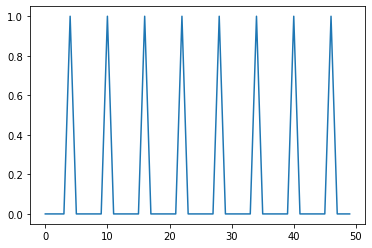

In [ ]:
plt.plot(list(range(50)), dist_next_chunk[650:700])

In [ ]:
ds_chk_seq["train"][20000:21000]["hl_dist_next_disc"]

[[5.0, 5.0, 5.0, 5.0],
 [5.0, 5.0, 5.0, 5.0],
 [5.0, 5.0, 5.0, 5.0],
 [5.0, 5.0, 5.0, 5.0],
 [5.0, 5.0, 5.0, 5.0],
 [5.0, 5.0, 5.0, 5.0],
 [5.0, 5.0, 5.0, 5.0],
 [5.0, 5.0, 5.0, 5.0],
 [5.0, 5.0, 5.0, 2.0],
 [5.0, 2.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 1.0],
 [0.0, 1.0, 1.0, 1.0],
 [1.0, 1.0, 3.0, 2.0],
 [3.0, 2.0, 3.0, 4.0],
 [3.0, 4.0, 4.0, 5.0],
 [4.0, 5.0, 5.0, 5.0],
 [5.0, 5.0, 5.0, 5.0],
 [5.0, 5.0, 5.0, 5.0],
 [5.0, 5.0,

In [ ]:
ds_chk_seq["train"][20000:21000]["highlights"]

[[1, 1, 1, 1],
 [1, 1, 1, 1],
 [1, 1, 1, 1],
 [1, 1, 1, 1],
 [1, 1, 1, 1],
 [1, 1, 1, 1],
 [1, 1, 1, 1],
 [1, 1, 1, 1],
 [1, 1, 1, 1],
 [1, 1, 0, 0],
 [0, 0, 0, 0],
 [0, 0, 0, 0],
 [0, 0, 0, 0],
 [0, 0, 0, 0],
 [0, 0, 0, 0],
 [0, 0, 0, 0],
 [0, 0, 0, 0],
 [0, 0, 0, 0],
 [0, 0, 0, 0],
 [0, 0, 0, 0],
 [0, 0, 0, 0],
 [0, 0, 0, 0],
 [0, 0, 0, 0],
 [0, 0, 0, 0],
 [0, 0, 0, 0],
 [0, 0, 0, 0],
 [0, 0, 0, 0],
 [0, 0, 0, 0],
 [0, 0, 0, 0],
 [0, 0, 0, 0],
 [0, 0, 0, 0],
 [0, 0, 0, 0],
 [0, 0, 0, 0],
 [0, 0, 0, 0],
 [0, 0, 0, 0],
 [0, 0, 0, 0],
 [0, 0, 0, 0],
 [0, 0, 0, 0],
 [0, 0, 0, 0],
 [0, 0, 1, 1],
 [1, 1, 1, 1],
 [1, 1, 1, 1],
 [1, 1, 1, 1],
 [1, 1, 1, 1],
 [1, 1, 1, 1],
 [1, 1, 1, 0],
 [1, 0, 0, 0],
 [0, 0, 0, 0],
 [0, 0, 0, 0],
 [0, 0, 0, 0],
 [0, 0, 0, 0],
 [0, 0, 0, 0],
 [0, 0, 0, 0],
 [0, 0, 0, 0],
 [0, 0, 0, 0],
 [0, 0, 0, 0],
 [0, 0, 0, 0],
 [0, 0, 0, 0],
 [0, 0, 0, 0],
 [0, 0, 0, 0],
 [0, 0, 0, 0],
 [0, 0, 0, 0],
 [0, 0, 0, 0],
 [0, 0, 0, 0],
 [0, 0, 0, 0],
 [0, 0, 0, 0],
 [0, 0, 0,

In [ ]:
# goal: 32 tokens per chunk 
# actual: 28.279
iids_lens = [len(e) for a in ds_new_data["input_ids"] for e in a]
np.mean(iids_lens)

28.27925815084458

In [ ]:
# goal: 128 tokens per sequence
# actual: 113.12
np.mean(iids_lens)*4

113.11703260337832

In [ ]:
new_data_seqs[6012]

In [ ]:
ds_chk_seq.save_to_disk("../Data/Fuetal2017/fu2017_highlight_detection_dataset_chunked_sequenced_targets")

In [ ]:
ds_chk_seq_targets = datasets.load_from_disk("../Data/Fuetal2017/fu2017_highlight_detection_dataset_chunked_sequenced_targets")

In [ ]:
ds_chk_seq_targets

DatasetDict({
    train: Dataset({
        features: ['highlights', 'input_ids', 'attention_mask', 'message_density_scaled', 'hl_dist_prev_disc', 'hl_dist_next_disc', 'hl_dist_start_disc', 'hl_dist_stop_disc'],
        num_rows: 104252
    })
    val: Dataset({
        features: ['highlights', 'input_ids', 'attention_mask', 'message_density_scaled', 'hl_dist_prev_disc', 'hl_dist_next_disc', 'hl_dist_start_disc', 'hl_dist_stop_disc'],
        num_rows: 33160
    })
    test: Dataset({
        features: ['highlights', 'input_ids', 'attention_mask', 'message_density_scaled', 'hl_dist_prev_disc', 'hl_dist_next_disc', 'hl_dist_start_disc', 'hl_dist_stop_disc'],
        num_rows: 34045
    })
})

In [ ]:
network_example_out = np.concatenate([ds_chk_seq_targets["train"][10000]["hl_dist_prev_disc"], ds_chk_seq_targets["train"][10000]["hl_dist_next_disc"], ds_chk_seq_targets["train"][10000]["hl_dist_start_disc"], ds_chk_seq_targets["train"][10000]["hl_dist_stop_disc"]], axis=-1)
network_example_out

array([5., 5., 5., 5., 5., 5., 5., 5., 0., 0., 0., 0., 0., 0., 1., 2.])

In [ ]:
torch.argmax(torch.Tensor(network_example_out), dim=-1)

tensor(0)

In [ ]:
def compute_labels(ex, context_size = (1,1)):
  return {"hl_labels": np.asarray(ex["highlights"][context_size[0]: -context_size[1]], dtype=float),
          "additional_labels": np.concatenate([ex["hl_dist_prev_disc"], ex["hl_dist_next_disc"], ex["hl_dist_start_disc"], ex["hl_dist_stop_disc"]], axis=-1)}

In [ ]:
ds_chk_seq_targets_labels = ds_chk_seq_targets.map(lambda examples: compute_labels(examples))

  0%|          | 0/104252 [00:00<?, ?ex/s]

  0%|          | 0/33160 [00:00<?, ?ex/s]

  0%|          | 0/34045 [00:00<?, ?ex/s]

In [ ]:
def compute_additional_features(ex):
  return {"additional_features":  ex["message_density_scaled"]}

In [ ]:
ds_chk_seq_targets_labels = ds_chk_seq_targets_labels.map(lambda examples: compute_additional_features(examples))

  0%|          | 0/104252 [00:00<?, ?ex/s]

  0%|          | 0/33160 [00:00<?, ?ex/s]

  0%|          | 0/34045 [00:00<?, ?ex/s]

In [ ]:
def pad_truncate_to_max_sequence_length(ex, pad_to=128):
  pad_token_id = tokenizer.pad_token_id
  assert len(ex["input_ids"]) == len(ex["attention_mask"])
  
  if len(ex["input_ids"]) >= pad_to:
    # truncate
    return {
      "input_ids": np.asarray(ex["input_ids"][:pad_to], dtype=float),
      "attention_mask": np.asarray(ex["attention_mask"][:pad_to], dtype=float)
      }
  else:
    # pad
    return {
      "input_ids": np.concatenate([ex["input_ids"], np.full((pad_to - len(ex["input_ids"])), pad_token_id)], axis=-1, dtype=float),
      "attention_mask": np.concatenate([ex["attention_mask"], np.full((pad_to - len(ex["attention_mask"])), 0)], axis=-1, dtype=float)
    }

In [ ]:
ds_chk_seq_targets_padded = ds_chk_seq_targets_labels.map(lambda examples: pad_truncate_to_max_sequence_length(examples))

  0%|          | 0/104252 [00:00<?, ?ex/s]

  0%|          | 0/33160 [00:00<?, ?ex/s]

  0%|          | 0/34045 [00:00<?, ?ex/s]

In [ ]:
ds_chk_seq_targets_padded

DatasetDict({
    train: Dataset({
        features: ['highlights', 'input_ids', 'attention_mask', 'message_density_scaled', 'hl_dist_prev_disc', 'hl_dist_next_disc', 'hl_dist_start_disc', 'hl_dist_stop_disc', 'hl_labels', 'additional_labels', 'additional_features'],
        num_rows: 104252
    })
    val: Dataset({
        features: ['highlights', 'input_ids', 'attention_mask', 'message_density_scaled', 'hl_dist_prev_disc', 'hl_dist_next_disc', 'hl_dist_start_disc', 'hl_dist_stop_disc', 'hl_labels', 'additional_labels', 'additional_features'],
        num_rows: 33160
    })
    test: Dataset({
        features: ['highlights', 'input_ids', 'attention_mask', 'message_density_scaled', 'hl_dist_prev_disc', 'hl_dist_next_disc', 'hl_dist_start_disc', 'hl_dist_stop_disc', 'hl_labels', 'additional_labels', 'additional_features'],
        num_rows: 34045
    })
})

In [ ]:
ds_chk_seq_targets_padded["train"][10000]["additional_labels"]

[5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 2.0]

In [ ]:
def simple_additional_objective(ex, max_val=5):
  res = list()
  for dat in zip(ex["hl_dist_prev_disc"], ex["hl_dist_next_disc"], ex["hl_dist_start_disc"], ex["hl_dist_stop_disc"]):
    dat = [d if d < max_val else 0 for d in dat]
    res.append(1. if max(dat) < max_val and max(dat) > 0 else 0.)
  return {"objective_simple": np.asarray(res)}

In [ ]:
ds_chk_seq_targets_padded_simple = ds_chk_seq_targets_padded.map(lambda example: simple_additional_objective(example))

  0%|          | 0/104252 [00:00<?, ?ex/s]

  0%|          | 0/33160 [00:00<?, ?ex/s]

  0%|          | 0/34045 [00:00<?, ?ex/s]

In [ ]:
ds_chk_seq_targets_padded_simple["train"][:100]["objective_simple"]

[[0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0,

In [ ]:
ds_chk_seq_targets_padded_simple.save_to_disk("../Data/Fuetal2017/fu2017_highlight_detection_dataset_chunked_sequenced_targets_simple")

In [ ]:
ds_chk_seq_targets_padded_simple = datasets.load_from_disk("../Data/Fuetal2017/fu2017_highlight_detection_dataset_chunked_sequenced_targets_simple")

In [ ]:
ds_chk_seq_targets_padded_simple

DatasetDict({
    train: Dataset({
        features: ['highlights', 'input_ids', 'attention_mask', 'message_density_scaled', 'hl_dist_prev_disc', 'hl_dist_next_disc', 'hl_dist_start_disc', 'hl_dist_stop_disc', 'hl_labels', 'additional_labels', 'additional_features', 'objective_simple'],
        num_rows: 104252
    })
    val: Dataset({
        features: ['highlights', 'input_ids', 'attention_mask', 'message_density_scaled', 'hl_dist_prev_disc', 'hl_dist_next_disc', 'hl_dist_start_disc', 'hl_dist_stop_disc', 'hl_labels', 'additional_labels', 'additional_features', 'objective_simple'],
        num_rows: 33160
    })
    test: Dataset({
        features: ['highlights', 'input_ids', 'attention_mask', 'message_density_scaled', 'hl_dist_prev_disc', 'hl_dist_next_disc', 'hl_dist_start_disc', 'hl_dist_stop_disc', 'hl_labels', 'additional_labels', 'additional_features', 'objective_simple'],
        num_rows: 34045
    })
})

### class weights for imbalanced dataset


In [ ]:
num_highlight_chunks = sum(np.ravel(ds_chk_seq_targets_padded_simple["train"]["hl_labels"]))
num_highlight_chunks

28358.0

In [ ]:
num_total_chunks = len(np.ravel(ds_chk_seq_targets_padded_simple["train"]["hl_labels"]))
num_total_chunks

208504

In [ ]:
num_highlight_chunks / num_total_chunks

0.1360069830794613

## Model definition

https://github.com/abhimishra91/transformers-tutorials/blob/master/
transformers_multi_label_classification.ipynb

In [ ]:
"""
class LanguageModelPlusTemporalExtra(torch.nn.Module):

  # TODO
  # make a ModelConfig argument and Class to set the parameters for the model

  # With additional objectives for closeness to highlight boundary
  def __init__(self, lm_path, additional_features_size, window_size, sequence_length, num_dist_categories, num_dist_steps, main_loss_ratio=1):
        super(LanguageModelPlusTemporal, self).__init__()

        self.additional_features_size = additional_features_size # just random value for now
        self.window_size = window_size
        self.loss1_ratio = main_loss_ratio
        self.loss2_ratio = 1 - main_loss_ratio
        self.l1 = RobertaModel.from_pretrained(lm_path)
        self.d1 = torch.nn.Dropout(0.3)
        self.l3 = torch.nn.Linear(128 + self.additional_features_size, 1024) # should be model_output_size (sequence length) + additional_features_size
        # maybe I should translate the additional features to a bigger
        # vectorspace so that they do not get drowned out by the sequence representation
        self.l41 = torch.nn.Linear(1024, window_size)
        # for each chunk in a sequence we have num_distcategories and each category has num_dist_steps number of discrete labels
        self.l42 = torch.nn.Linear(1024, sequence_length) # might have to add more here for each class and possible value
        # l42: maybe combine in-highlight output and outside-highlight output
    
  def forward(self, input_ids, attention_mask, additional_features, hl_labels=None, objective_simple=None, **kwargs):
        output_1 = self.l1(input_ids, attention_mask = attention_mask) # last_hidden_state, pooler_output
        # average lm last hidden layer outputs
        # alterntively use pooled output
        output_1_average = torch.mean(output_1.last_hidden_state, axis=-1)
        # concatenate sequence representation with additional temporal features
        input_2 = torch.concat([output_1_average, additional_features], axis=-1)
        # dropout
        output_2 = self.d1(input_2)
        # linear
        output_3 = self.l3(output_2)
        # for binary classification of main objective
        # define to return
        output_41 = self.l41(output_3)
        # for multiclass classification of additional objective
        output_42 = self.l42(output_3)
        outputs = [output_41, output_42]

        # print("hl_labels", hl_labels is not None)
        # print("objective_simple", objective_simple is not None)
        # for compatibility with the huggingface Trainer API
        if hl_labels is not None and objective_simple is not None:
          loss = self._combined_loss(outputs, (hl_labels, objective_simple))
          # TODO add normalization before returning outputs
          return {"loss": loss[0],
                  "separate_losses": loss[1],
                  "logits": outputs}

        return {"logits": outputs}

  def _combined_loss(self, outputs, targets):
    # for o, t in zip(outputs[0], targets[0]):
      # loss += torch.nn.BCEWithLogitsLoss()(o, t)
    # does this actually do what I want?
    # compute losses for n (window_size) outputs?
    loss1 = torch.nn.BCEWithLogitsLoss()(outputs[0], targets[0]) # keep as is
    # print(outputs[1].size())
    # print(targets[1].size())
    loss2 = torch.nn.CrossEntropyLoss()(outputs[1], targets[1]) # split into multiple softmaxes and losses
    

    # weighting of losses (schould be fine-tuned as well)
    # for example
    # loss1 * 0.9
    # loss2 * 0.1
    # log both losses => make sure both go down
    losses = [loss1 * self.loss1_ratio, loss2 * self.loss2_ratio]
    return sum(losses), losses
"""

In [ ]:
class LanguageModelPlusTemporal(torch.nn.Module):
  """
  TODO
  make a ModelConfig argument and Class to set the parameters for the model

  """
  def __init__(self, lm_path, additional_features_size, window_size, sequence_length, num_dist_categories, num_dist_steps, main_loss_ratio=1, pos_label_ratio=7.35):
        super(LanguageModelPlusTemporal, self).__init__()

        self.additional_features_size = additional_features_size # just random value for now
        self.window_size = window_size
        self.loss1_ratio = main_loss_ratio
        self.loss2_ratio = 1 - main_loss_ratio
        self.pos_label_ratio = torch.Tensor([pos_label_ratio]).to(device)
        self.l1 = RobertaModel.from_pretrained(lm_path)
        self.d1 = torch.nn.Dropout(0.3)
        self.l3 = torch.nn.Linear(128 + self.additional_features_size, 1024) # should be model_output_size (sequence length) + additional_features_size
        # maybe I should translate the additional features to a bigger
        # vectorspace so that they do not get drowned out by the sequence representation
        self.l41 = torch.nn.Linear(1024, window_size)
        # for each chunk in a sequence we have num_distcategories and each category has num_dist_steps number of discrete labels
        self.l42 = torch.nn.Linear(1024, sequence_length) # might have to add more here for each class and possible value
        # l42: maybe combine in-highlight output and outside-highlight output
    
  def forward(self, input_ids, attention_mask, additional_features, hl_labels=None, objective_simple=None, **kwargs):
        output_1 = self.l1(input_ids, attention_mask = attention_mask) # last_hidden_state, pooler_output
        # average lm last hidden layer outputs
        # alterntively use pooled output
        output_1_average = torch.mean(output_1.last_hidden_state, axis=-1)
        # concatenate sequence representation with additional temporal features
        input_2 = torch.concat([output_1_average, additional_features], axis=-1)
        # dropout
        output_2 = self.d1(input_2)
        # linear
        output_3 = self.l3(output_2)
        # for binary classification of main objective
        # define to return
        output = self.l41(output_3)
        # for multiclass classification of additional objective
        #output_42 = self.l42(output_3)
        #outputs = [output_41, output_42]

        # print("hl_labels", hl_labels is not None)
        # print("objective_simple", objective_simple is not None)
        # for compatibility with the huggingface Trainer API
        if hl_labels is not None:
          loss = self._get_loss(output, hl_labels)
          # TODO add normalization before returning outputs
          return {"loss": loss,
                  "logits": torch.sigmoid(output)}

        return {"logits": torch.sigmoid(output)}

  def _get_loss(self, outputs, targets):
    """
    for o, t in zip(outputs[0], targets[0]):
      loss += torch.nn.BCEWithLogitsLoss()(o, t)
    """
    # does this actually do what I want?
    # compute losses for n (window_size) outputs?
    # we can add weighing for the much smaller positive class with pos_weight
    loss1 = torch.nn.BCEWithLogitsLoss(pos_weight=self.pos_label_ratio)(torch.reshape(outputs, (outputs.shape[0]*self.window_size, 1)), torch.reshape(targets, (targets.shape[0]*self.window_size, 1))) # keep as is
    # print(outputs[1].size())
    # print(targets[1].size())
    # loss2 = torch.nn.CrossEntropyLoss()(outputs[1], targets[1]) # split into multiple softmaxes and losses
    

    # weighting of losses (schould be fine-tuned as well)
    # for example
    # loss1 * 0.9
    # loss2 * 0.1
    # log both losses => make sure both go down
    # losses = [loss1 * self.loss1_ratio, loss2 * self.loss2_ratio]
    return loss1

In [ ]:
model = LanguageModelPlusTemporal("./TwitchLeagueBert/", window_size=2, additional_features_size=4, sequence_length=4, num_dist_categories=4, num_dist_steps=6, main_loss_ratio=0.7, pos_label_ratio=7.35)

Some weights of the model checkpoint at ./TwitchLeagueBert/ were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at ./TwitchLeagueBert/ and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.loss1_ratio, model.loss2_ratio

(0.7, 0.30000000000000004)

In [ ]:
model.to(device)

LanguageModelPlusTemporal(
  (l1): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerN

## Define trainer

Some notes from huggingface for custom models:

https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.TrainingArguments

The Trainer class is optimized for 🤗 Transformers models and can have surprising behaviors when you use it on other models. When using it on your own model, make sure:

* your model always return tuples or subclasses of ModelOutput.
* your model can compute the loss if a labels argument is provided and that loss is returned as the first element of the tuple (if your model returns tuples)
* your model can accept multiple label arguments (use the label_names in your TrainingArguments to indicate their name to the Trainer) but none of them should be named "label".



In [ ]:
f1_metric = datasets.load_metric("f1")
p_metric = datasets.load_metric("precision")
r_metric = datasets.load_metric("recall")
metrics = [f1_metric, p_metric, r_metric]

In [ ]:
dict(ChainMap(*[m.compute(predictions=[0, 1, 1], references=[0, 0, 1]) for m in metrics]))

{'f1': 0.6666666666666666, 'precision': 0.5, 'recall': 1.0}

In [ ]:
def preprocess_logits_for_metrics(logits, labels):
  return torch.round(logits)

In [ ]:
def compute_metrics(p):
  # https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
  refs = p.label_ids

  preds = torch.Tensor(np.ravel(preds))
  refs = torch.tensor(np.ravel(refs))

  results = dict(ChainMap(*[m.compute(predictions=preds, references=refs) for m in metrics]))
  return results

In [ ]:
pred_test = torch.Tensor([[0.8,0.9], [0.7,0.2]])
labels_test = np.asarray([[1,1],[0,0]])

# pred_test = torch.Tensor([[0,0], [0,0]])
# labels_test = np.asarray([[1,0]optional,[0,0]])

compute_metrics(transformers.EvalPrediction(predictions=preprocess_logits_for_metrics(pred_test, labels=labels_test).numpy(), label_ids=labels_test))

{'f1': 0.8, 'precision': 0.6666666666666666, 'recall': 1.0}

In [ ]:
# custom trainer

class MultiObjectiveTrainer(LanguageModelPlusTemporal):
  def __init__(self, **kwargs):
    self.super.__init__(**kwargs)


In [ ]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
  output_dir="./LMPlusTemporal",
  overwrite_output_dir=True,
  num_train_epochs=3,
  per_device_train_batch_size=64,
  save_steps=500,
  save_total_limit=4,
  evaluation_strategy="steps",
  eval_steps=250,
  logging_steps=100,
  report_to="all",
  label_names=["hl_labels"] # , "objective_simple"]
)

trainer = Trainer(
  model=model,
  compute_metrics=compute_metrics,
  preprocess_logits_for_metrics=preprocess_logits_for_metrics,
  args=training_args,
  train_dataset=ds_chk_seq_targets_padded_simple["train"],
  # train_dataset=datasets.Dataset.from_dict(ds_chk_seq_targets_padded_simple["train"][:4096]),
  eval_dataset=ds_chk_seq_targets_padded_simple["val"]
  # eval_dataset=datasets.Dataset.from_dict(ds_chk_seq_targets_padded_simple["val"][:64])
  # callbacks=[FileWriterCallback(log_file_path="./", log_file_final_path="./")]
)

PyTorch: setting up devices


In [ ]:
val_test = datasets.Dataset.from_dict(ds_chk_seq_targets_padded_simple["val"][:64])

In [ ]:
train_result = trainer.train()

The following columns in the training set  don't have a corresponding argument in `LanguageModelPlusTemporal.forward` and have been ignored: hl_dist_start_disc, message_density_scaled, additional_labels, hl_dist_next_disc, highlights, hl_dist_prev_disc, hl_dist_stop_disc. If hl_dist_start_disc, message_density_scaled, additional_labels, hl_dist_next_disc, highlights, hl_dist_prev_disc, hl_dist_stop_disc are not expected by `LanguageModelPlusTemporal.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 104252
  Num Epochs = 3
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Grad

Step,Training Loss,Validation Loss,Recall,Precision,F1
250,1.078100,1.112906,0.519540,0.463663,0.490013
500,0.942800,0.959002,0.742712,0.381573,0.504140
750,0.883000,0.940270,0.778623,0.360612,0.492929
1000,0.797700,0.952425,0.732573,0.395394,0.513588
1250,0.819200,0.907755,0.801542,0.362607,0.499326
1500,0.763600,0.925490,0.758238,0.382554,0.508536
1750,0.655600,1.139419,0.589565,0.462584,0.518412
2000,0.587800,1.067212,0.720638,0.387582,0.504063
2250,0.583200,1.112693,0.655577,0.424701,0.515467
2500,0.576600,1.095083,0.671208,0.398683,0.500236


The following columns in the evaluation set  don't have a corresponding argument in `LanguageModelPlusTemporal.forward` and have been ignored: hl_dist_start_disc, message_density_scaled, additional_labels, hl_dist_next_disc, highlights, hl_dist_prev_disc, hl_dist_stop_disc. If hl_dist_start_disc, message_density_scaled, additional_labels, hl_dist_next_disc, highlights, hl_dist_prev_disc, hl_dist_stop_disc are not expected by `LanguageModelPlusTemporal.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 33160
  Batch size = 8
The following columns in the evaluation set  don't have a corresponding argument in `LanguageModelPlusTemporal.forward` and have been ignored: hl_dist_start_disc, message_density_scaled, additional_labels, hl_dist_next_disc, highlights, hl_dist_prev_disc, hl_dist_stop_disc. If hl_dist_start_disc, message_density_scaled, additional_labels, hl_dist_next_disc, highlights, hl_dist_prev_disc, hl_dist_stop_disc are not expected 

In [ ]:
# https://stackoverflow.com/questions/68806265/huggingface-trainer-logging-train-data
with open(f"{trainer.args.logging_dir}/log_history.json", "w") as out_file:
  json.dump(trainer.state.log_history, out_file, indent=4)

NameError: ignored

In [ ]:
trainer.save_model(f"{trainer.args.output_dir}/final_model")

## Forward pass example

'', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '4 2 0', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 'you guys suck', '', '', '', '', '', '', '', 'mods what patch???', '', '', '', '', '', '', '', '', '', '', '', 'My butthole hurts SneakyW waitingroom ResidentSleeper', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '90k PPL AND NO Kappa SPAM?', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 'forsen1 forsen2', '', '', '', '', '', '', '', 'forsen1 forsen2', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 'LUL', '', '', '', '', 'phunkFail', '', '', '', '', 'forsen3 forsen4 forsenE', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 'LUL', '', 'forsen1 forsen2 COMBO ME', '', '', '', '', '', '', '', 'lul', '', 'SINGED LUL', '', '', '', '', '', '', '', '', '', '', '', "FeelsBadMan 🐢 You're not Doublelift FeelsBadMan", '', '', '', '', 'boatyD boatyR', '', '', '', 'FREESM LUL', '', '', '', '', '', '', '', '', '', '', '????', '', '', '', '', '', '', '', '', 'TSM LUL', 'PogChamp', 'ALLY OOP', 'cy@ tsm', '', '', '', '', '', '', '', '', '', '', '', '', 'PogChamp', '', '', '', '', 'SINGED LOL', '', '', '', '', 'LOL', '', '', '', '', '', '', '', '', '', '', '', '', 'TURT LUL', '', 'PogChamp', '', '', '', '', '', 'L O L', '', '', '', '', '', '', '', '', '', '', 'OOO', '', '', 'FeelsRageMan', 'PogChamp', 'PogChamp', 'haHAA @ 13:37 haHAA @ 13:37 haHAA @ 13:37', 'PogChamp', '', '', '', 'PogChamp', 'team?', '', '', '', '', 'LUL', '', '', 'lul', '', '', '', 'LUL', 'HAHAHAHAHAHA TSM', '', 'TSM LUL', '', '', '', '', 'LUL', '', '', '', '', '', 'boatyU boatyG', 'LUL', 'PogChamp', '', '', '', '', '', '', 'PogChamp', '', '', '', '', '', '', '', 'TSM in 2017 LUL', '', 'PogChamp Fox', '', '', '', 'PogChamp', '', 'TSM LUL', '', '', 'PogChamp', '', 'LUL', '', '', '', '', '', '', '', '', '', 'PogChamp', '', '', '', '', '', '', 'freesm', 'aaahaha', 'PogChamp', 'ECHO FOX PogChamp', 'PogChamp']

In [ ]:
ex_simple = ['when normies dont understand memes REEEEEE', '', '', '', 'forsen3 forsen4 I GOT THIS', '', '', '', '', '', '', '', '', '', '', '', '', '', '1 FOR IVANKA Kreygasm', 'TSM FANS SO QUIET LUL', 'RED CANIDS> TSM']
ex_batched = [['when normies dont understand memes REEEEEE', '', '', '', 'forsen3 forsen4 I GOT THIS', '', '', '', '', '', '', '', '', '', '', '', '', '', '1 FOR IVANKA Kreygasm', 'TSM FANS SO QUIET LUL', 'RED CANIDS> TSM'],
              ['My butthole hurts SneakyW waitingroom ResidentSleeper', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '90k PPL AND NO Kappa SPAM?'],
              ['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 'forsen1 forsen2', '', '', '', '', '', '', '', 'forsen1 forsen2', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 'LUL', '', '', '', '', 'phunkFail'],
              ['PogChamp', 'PogChamp', 'haHAA @ 13:37 haHAA @ 13:37 haHAA @ 13:37', 'PogChamp', '', '', '', 'PogChamp', 'team?', '', '', '', '', 'LUL', '', '', 'lul', '', '', '', 'LUL', 'HAHAHAHAHAHA TSM']
              ]

ex_batched = ["</s><s>".join(e) for e in ex_batched]

example_toked = tokenizer(ex_batched, padding=True, truncation=True, pad_to_multiple_of=128)

In [ ]:
len(example_toked["input_ids"])

4

In [ ]:
sum([len(s) for s in example_toked["input_ids"]])

512

In [ ]:
tokenizer.pad_token_id

1

In [ ]:
example_toked["additional_features"] = [[random.random() for i in range(4)] for _ in range(4)]

In [ ]:
# LR_schedule = transformers.get_linear_schedule_with_warmup()

In [ ]:
input_ids = torch.IntTensor(example_toked["input_ids"]).to(device)
attention_mask = torch.IntTensor(example_toked["attention_mask"]).to(device)
additional_features = torch.FloatTensor(example_toked["additional_features"]).to(device)
targets = torch.Tensor([[0,0],[0,1],[1,1],[1,1]]).to(device)

In [ ]:
targets.shape[0]

4

In [ ]:
# model_result = model(input_ids, attention_mask, additional_features, labels="label", hl_labels=torch.Tensor(np.asarray([[0, 0]])), objective_simple=torch.Tensor(np.zeros((1,4))))

model_result = model(input_ids, attention_mask, additional_features, labels="label", hl_labels=targets)

In [ ]:
model_result

{'logits': tensor([[0.5040, 0.4742],
         [0.5101, 0.5001],
         [0.5090, 0.4851],
         [0.5006, 0.4884]], device='cuda:0', grad_fn=<SigmoidBackward0>),
 'loss': tensor(0.6947, device='cuda:0',
        grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)}

In [ ]:
model_result["loss"].backward()

In [ ]:
model_result["separate_losses"][0], model_result["separate_losses"][1]

#### eval test

In [ ]:
trainer.evaluate()

The following columns in the evaluation set  don't have a corresponding argument in `LanguageModelPlusTemporal.forward` and have been ignored: message_density_scaled, hl_dist_prev_disc, hl_dist_stop_disc, hl_dist_next_disc, highlights, additional_labels, hl_dist_start_disc. If message_density_scaled, hl_dist_prev_disc, hl_dist_stop_disc, hl_dist_next_disc, highlights, additional_labels, hl_dist_start_disc are not expected by `LanguageModelPlusTemporal.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 100
  Batch size = 8


tensor([0., -0., 0., -0., 0., -0., 0., -0., 0., -0., 0., -0., 0., -0., 0., -0., 0., -0., 0., -0., 0., -0., 0., -0.,
        0., -0., 0., -0., 0., -0., 0., -0., 0., -0., 0., -0., 0., -0., 0., -0., 0., -0., 0., -0., 0., -0., 0., -0.,
        0., -0., 0., -0., 0., -0., 0., -0., 0., -0., 0., -0., 0., -0., 0., -0., 0., -0., 0., -0., 0., -0., 0., -0.,
        0., -0., 0., -0., 0., -0., 0., -0., 0., -0., 0., -0., 0., -0., 0., -0., 0., -0., 0., -0., 0., -0., 0., -0.,
        0., -0., 0., -0., 0., -0., 0., -0., 0., -0., 0., -0., 0., -0., 0., -0., 0., -0., 0., -0., 0., -0., 0., -0.,
        0., -0., 0., -0., 0., -0., 0., -0., 0., -0., 0., -0., 0., -0., 0., -0., 0., -0., 0., -0., 0., -0., 0., -0.,
        0., -0., 0., -0., 0., -0., 0., -0., 0., -0., 0., -0., 0., -0., 0., -0., 0., -0., 0., -0., 0., -0., 0., -0.,
        0., -0., 0., -0., 0., -0., 0., -0., 0., -0., 0., -0., 0., -0., 0., -0., 0., -0., 0., -0., 0., -0., 0., -0.,
        0., -0., 0., -0., 0., -0., 0., -0.])
tensor([0., 0., 0., 0., 0.,

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_f1': 0.0,
 'eval_loss': 0.7010490298271179,
 'eval_precision': 0.0,
 'eval_recall': 0.0,
 'eval_runtime': 18.3773,
 'eval_samples_per_second': 5.441,
 'eval_steps_per_second': 0.707}

## Test Copy Column

In [21]:
ds_messages_tok_count_oversampled = datasets.load_dataset("Epidot/private_fuetal2017_highlights_temporal_preprocessed_roberta-base_oversampled", use_auth_token=HUB_TOKEN)

Downloading:   0%|          | 0.00/1.93k [00:00<?, ?B/s]

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/Epidot___parquet/Epidot--private_fuetal2017_highlights_temporal_preprocessed_roberta-base_oversampled-31f9e940716c2eb3/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [22]:
ds_messages_tok_count_oversampled

DatasetDict({
    train: Dataset({
        features: ['highlights', 'input_ids', 'attention_mask', 'message_density_scaled', 'highlights_raw', 'hl_labels', 'additional_features'],
        num_rows: 330309
    })
    val: Dataset({
        features: ['highlights', 'input_ids', 'attention_mask', 'message_density_scaled', 'highlights_raw', 'hl_labels', 'additional_features'],
        num_rows: 50487
    })
    test: Dataset({
        features: ['highlights', 'input_ids', 'attention_mask', 'message_density_scaled', 'highlights_raw', 'hl_labels', 'additional_features'],
        num_rows: 51926
    })
})

In [ ]:
def copy_column(example, cname, cname_new):
  example[cname_new] = example[cname]
  return example

In [ ]:
copy_args = {"cname": "highlights", "cname_new":"highlights_raw"}

In [ ]:
ds_messages_tok_count_oversampled_copied = ds_messages_tok_count_oversampled.map(copy_column, fn_kwargs=copy_args)

  0%|          | 0/33160 [00:00<?, ?ex/s]

  0%|          | 0/34046 [00:00<?, ?ex/s]

  0%|          | 0/215089 [00:00<?, ?ex/s]

In [ ]:
ds_messages_tok_count_oversampled_copied

DatasetDict({
    val: Dataset({
        features: ['highlights', 'input_ids', 'attention_mask', 'message_density_scaled', 'hl_labels', 'additional_features', 'highlights_raw'],
        num_rows: 33160
    })
    test: Dataset({
        features: ['highlights', 'input_ids', 'attention_mask', 'message_density_scaled', 'hl_labels', 'additional_features', 'highlights_raw'],
        num_rows: 34046
    })
    train: Dataset({
        features: ['highlights', 'input_ids', 'attention_mask', 'message_density_scaled', 'hl_labels', 'additional_features', 'highlights_raw'],
        num_rows: 215089
    })
})

In [ ]:
ds_messages_tok_count_oversampled_copied

In [ ]:

def compute_labels(ex, context_size=(1, 1)):
    return {"hl_labels": np.asarray(ex["highlights"][context_size[0]: -context_size[1]], dtype=float)}

"""
            "additional_labels": np.concatenate(
                [ex["hl_dist_prev_disc"], ex["hl_dist_next_disc"], ex["hl_dist_start_disc"], ex["hl_dist_stop_disc"]],
                axis=-1)}
"""


def compute_additional_features(ex):
    return {"additional_features": ex["message_density_scaled"]}


def pad_truncate_to_max_sequence_length(ex, pad_token_id, pad_to):
    assert len(ex["input_ids"]) == len(ex["attention_mask"])

    if len(ex["input_ids"]) >= pad_to:
        # truncate
        return {
            "input_ids": np.asarray(ex["input_ids"][:pad_to], dtype=float),
            "attention_mask": np.asarray(ex["attention_mask"][:pad_to], dtype=float)
        }
    else:
        # pad
        return {
            "input_ids": np.concatenate([ex["input_ids"], np.full((pad_to - len(ex["input_ids"])), pad_token_id)],
                                        axis=-1).astype(np.float),
            "attention_mask": np.concatenate([ex["attention_mask"], np.full((pad_to - len(ex["attention_mask"])), 0)],
                                             axis=-1).astype(np.float)
        }

In [ ]:
def restructure_data_for_model(ds, tokenizer_name, pad_to):
    tokenizer = RobertaTokenizerFast.from_pretrained(tokenizer_name)
    ds = ds.map(lambda examples: compute_labels(examples))
    ds = ds.map(lambda examples: compute_additional_features(examples))
    ds = ds.map(lambda examples: pad_truncate_to_max_sequence_length(examples, tokenizer.pad_token_id, pad_to))
    ds = ds.map(lambda examples: {"highlights_raw": examples["highlights_raw"]})
    return ds

In [ ]:
restructure_data_for_model(ds_messages_tok_count_oversampled_copied["val"], "Epidot/TwitchLeagueBert-1000k", pad_to=128)

  0%|          | 0/33160 [00:00<?, ?ex/s]

  0%|          | 0/33160 [00:00<?, ?ex/s]

  0%|          | 0/33160 [00:00<?, ?ex/s]

  0%|          | 0/33160 [00:00<?, ?ex/s]

Dataset({
    features: ['highlights', 'input_ids', 'attention_mask', 'message_density_scaled', 'hl_labels', 'additional_features', 'highlights_raw'],
    num_rows: 33160
})